In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, AugmentedDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
def return_all_items(dataset):
    all_items = []
    print(len(dataset))
    for i in range(len(dataset)):
        all_items.append(dataset[i])
        print(dataset[i])
        break
    return all_items

In [3]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_audio = '..\\data\\MELD\\audio\\wav\\'
val_audio = '..\\data\\MELD\\audio\\wav_dev\\'
test_audio = '..\\data\\MELD\\audio\\wav_test\\'

In [4]:
em = True
train = AudioDataset(train_annotations, train_audio, emotion=em)



In [9]:

val = AudioDataset(val_annotations, val_audio, emotion=em)

train_dataloader = DataLoader(train, batch_size=64, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=len(val), shuffle=False, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))

In [10]:
# Sanity check: Size should be [batch_size, num_features, feature_vector_len], [batch_size]
# Where batch size is 32, num_features (num mfccs, num mel) is 104
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# Length should be 9988*2
print(f"Length of the train data: {len(train)}")

Feature batch shape: torch.Size([64, 104])
Labels batch shape: torch.Size([64])
Length of the train data: 9988


In [11]:
for batch in train_dataloader:
    x, y = batch
    print(x.shape, y.shape)
    break


torch.Size([64, 104]) torch.Size([64])


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if em:
    weight=torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989]).to(device=device)
else:
    weight=torch.tensor([1-2945/9989, 1-2334/9989, 1-4710/9989]).to(device=device)



In [13]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss(weight=weight, label_smoothing=0.0)(input=predictions,target=targets)

In [14]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100, f1
    return train_step

In [15]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, f1, predictions
    return validate

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten(input_dim = 104, hidden_dim=128, output_dim=7, num_layers=3, bidirectional=False).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-2)


Number of trainable params:  483847


In [36]:
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 100
best_val_f1 = 0.3

for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, val_f1, _ = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), f'best-model-parameters-audio-sent1.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
        
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, f1:{f1:.2f}, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%, val_f1:{val_f1:.2f}")


Epoch 1 --> loss:1.1037, acc:39.06%, f1:0.86, val_loss:1.0981, val_acc:42.78%, val_f1:0.34

Epoch 2 --> loss:1.0961, acc:44.28%, f1:0.00, val_loss:1.0962, val_acc:41.43%, val_f1:0.32

Epoch 3 --> loss:1.0942, acc:44.13%, f1:0.10, val_loss:1.0939, val_acc:42.69%, val_f1:0.34

Epoch 4 --> loss:1.0943, acc:43.90%, f1:0.00, val_loss:1.0903, val_acc:43.77%, val_f1:0.33

Epoch 5 --> loss:1.0941, acc:44.35%, f1:0.64, val_loss:1.0980, val_acc:43.50%, val_f1:0.30

Epoch 6 --> loss:1.0942, acc:45.67%, f1:0.10, val_loss:1.0913, val_acc:42.24%, val_f1:0.32

Epoch 7 --> loss:1.0930, acc:45.36%, f1:0.25, val_loss:1.0906, val_acc:44.04%, val_f1:0.35

Epoch 8 --> loss:1.0934, acc:45.55%, f1:0.33, val_loss:1.0896, val_acc:44.95%, val_f1:0.34

Epoch 9 --> loss:1.0918, acc:46.31%, f1:0.20, val_loss:1.0939, val_acc:43.32%, val_f1:0.29

Epoch 10 --> loss:1.0927, acc:46.02%, f1:0.64, val_loss:1.0914, val_acc:44.31%, val_f1:0.32

Epoch 11 --> loss:1.0923, acc:46.35%, f1:0.64, val_loss:1.0904, val_acc:43.77%

0.42259791393340973


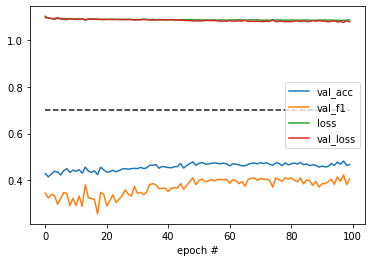

In [37]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,1), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')

ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print(best_val_f1)



In [7]:

test = AudioDataset(test_annotations, test_audio, emotion=em)




In [12]:
test_dataloader = DataLoader(test, batch_size=len(test), shuffle = False, drop_last=False)


In [39]:
torch.save(model.state_dict(), 'best-model-parameters-audio-sent2.pt')

In [14]:
model.load_state_dict(torch.load("best-model-parameters-audio-emo.pt"))

<All keys matched successfully>

In [13]:



device = 'cpu'
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    with torch.no_grad():
        output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None, labels=[0,1,2,3,4,5,6])
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# print(np.mean(f1s, axis = 0))
# print(np.mean(f1ss, axis = 0))
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.31656121205055987
[0.02724796 0.         0.         0.         0.65035147 0.
 0.        ]


In [ ]:
els = []
for el in f1s:
    if el.shape[0] == 6:
        els.append(el)
np.mean(els,axis=1)

array([0.18863446, 0.11452991, 0.12432012, 0.10622711, 0.12609649,
       0.13588691, 0.08615137, 0.16396316, 0.10855263, 0.15289855,
       0.11363636, 0.22304491])

0.1280856717489986


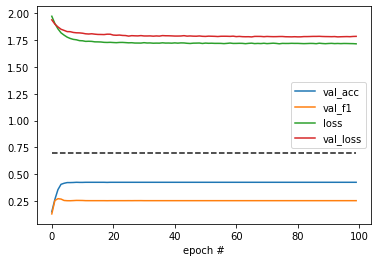